In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import os
from collections import defaultdict
from collections import Counter

import matplotlib.pyplot as plt

In [2]:
import psutil
psutil.cpu_count()
p = psutil.Process()
p.cpu_affinity([0,1,2,3,4,5,6,7,8])

In [3]:
os.chdir(r'H:\all\RL_Shrinkage_2024')
from helpers import helper_functions as hf

In [4]:
import glob

path = r'H:\all\RL_Shrinkage_2024\ONE_YR\NonLinear_Shrinkage\transformed_qis_eigenvalues'
extension = 'csv'
os.chdir(path)
filenames = glob.glob('*.{}'.format(extension))
print(filenames)

['cov2para_evs_df.csv', 'cov2para_fixed04_evs_df.csv', 'cov2para_plus02_evs_df.csv', 'qis_evs_df.csv', 'qis_evs_df_p100.csv', 'qis_evs_df_p225.csv', 'qis_evs_df_p30.csv', 'qis_evs_df_p50.csv', 'qis_evs_df_p500.csv', 'qis_evs_exp_05.csv', 'qis_evs_exp_2.csv', 'sample_evs_df.csv', 'sample_evs_df_p100.csv', 'sample_evs_df_p225.csv', 'sample_evs_df_p30.csv', 'sample_evs_df_p50.csv', 'sample_evs_df_p500.csv']


In [5]:
def get_ev_intensities(evs, sample_evs):
    intensities = evs.copy()
    if sample_evs.shape[1] == 500:
        intensities.iloc[:, -251:] = evs.iloc[:, -251:].values / sample_evs.iloc[:, -251:].values
    else:
        intensities = evs.values / sample_evs.values
    return intensities

def plot_last_x_intensities_across_time(intensities_dfs, modelnames, num_evs, return_df=False):
    if len(modelnames) > 1:
        dfs_list = [intensities_dfs[M].iloc[:, -num_evs:].mean(axis=1) for M in modelnames]
        df = pd.concat(dfs_list, axis=1)
        df.columns = modelnames
    else:
        df = intensities_dfs[modelnames[0]].iloc[:, -num_evs:].mean(axis=1)
        df.name = modelnames[0]
    fig = px.line(
        df,
        title = f"Plot of Average EV(Model) / EV(Sample) Across Time",
         labels={'value':f'Mean of EV(Model) / EV(Sample)'},
        height=700
    )
    fig.show()

def plot_last_x_intensities_across_assets(intensities_dfs, modelnames, num_evs, return_df=False):
    if len(modelnames) > 1:
        dfs_list = [intensities_dfs[M].iloc[:, -num_evs:].mean() for M in modelnames]
        df = pd.concat(dfs_list, axis=1)
        df.columns = modelnames
    else:
        df = intensities_dfs[modelnames[0]].iloc[:, -num_evs:].mean()
        df.name = modelnames[0]
        
    fig = px.line(
        df,
        title = f"Plot of Average EV(Model) / EV(Sample) Across Assets",
         labels={'value':f'Mean of EV(Model) / EV(Sample)', 'index': "Eigenvalue"},
        height=700
    )
    fig.show()


def plot_last_x_eigenvalues_across_time(eigenvalues_dfs, modelnames, ev_range, return_df=False):
    if len(modelnames) > 1:
        dfs_list = [eigenvalues_dfs[M].iloc[:, ev_range[0]:ev_range[1]].mean(axis=1) for M in modelnames]
        df = pd.concat(dfs_list, axis=1)
        df.columns = modelnames
    else:
        df = eigenvalues_dfs[modelnames[0]].iloc[:, ev_range[0]:ev_range[1]].mean(axis=1)
        df.name = modelnames[0]
    fig = px.line(
        df,
        title = f"Plot of Average EV(Model) Across Time",
         labels={'value':f'Mean of EV(Model) '},
        height=700
    )
    fig.show()

def plot_last_x_eigenvalues_across_assets(eigenvalues_dfs, modelnames, ev_range, return_df=False):
    if len(modelnames) > 1:
        dfs_list = [eigenvalues_dfs[M].iloc[:, ev_range[0]:ev_range[1]].mean() for M in modelnames]
        df = pd.concat(dfs_list, axis=1)
        df.columns = modelnames
    else:
        df = eigenvalues_dfs[modelnames[0]].iloc[:, ev_range[0]:ev_range[1]].mean()
        df.name = modelnames[0]
        
    fig = px.line(
        df,
        title = f"Plot of Average EV(Model) Across Assets",
         labels={'value':f'Mean of EV(Model)', 'index': "Eigenvalue"},
        height=700
    )
    fig.show()


def get_rawres(eigenvalue_dict, modelnames: list):
    tmp_res = defaultdict(list)
    tmp_rawres = defaultdict(list)
    for idx in range(0, permnos.shape[0]):
        try:
            past_ret_mat = rets_full[permnos.iloc[idx]].iloc[idx + add_idx - 21 * 12 * 1: idx + add_idx, :]
            past_ret_mat = past_ret_mat.sub(past_ret_mat.mean())
            past_ret_mat = past_ret_mat.fillna(0)
            fut_ret_mat = rets_full[permnos.iloc[idx]].iloc[idx + add_idx: idx + add_idx + 21, :]
        except:
            print("Some Error..")
            
        N, p = past_ret_mat.shape
        sample = pd.DataFrame(np.matmul(past_ret_mat.T.to_numpy(), past_ret_mat.to_numpy())) / (N - 1)
        lambda1, u = np.linalg.eigh(sample)
        lambda1 = lambda1.real.clip(min=0)
        dfu = pd.DataFrame(u,columns=lambda1)
        dfu.sort_index(axis=1,inplace = True)
        temp1 = dfu.to_numpy()
        temp3 = dfu.T.to_numpy().conjugate()

        for cur_modelname in modelnames:
            qis = eigenvalue_dict[cur_modelname].iloc[idx, :]
            temp2 = np.diag(qis)
            sigmahat = pd.DataFrame(np.matmul(np.matmul(temp1, temp2), temp3))
            try:
                weights = hf.calc_global_min_variance_pf(sigmahat)
            except:
                print("Some Other Error..")
            # store results
            tmp_res[cur_modelname].append(np.std(fut_ret_mat @ weights, ddof=1) * np.sqrt(252) * 100)
            if idx % 21 == 0:
                tmp_rawres[cur_modelname] += list(fut_ret_mat @ weights)

    return tmp_rawres, tmp_res


def eval_model_outputs(res, show_fig=True):
    res = [30 if r > 30 else r for r in res]
    res = [0 if r < 0 else r for r in res]
    res = re_hf.map_preds_to_factors(res, all_factors)
    Y_eval = all_rawres
    Y_eval.columns = Y_eval.columns.astype(str)
    res_evaluated2 = re_hf.evaluate_all_factor_preds(res, Y_eval, len_train)
    datetime_index = pd.to_datetime(permnos.index, format="%Y%m%d")
    res_df = pd.DataFrame(np.array(res, dtype=float), index=datetime_index[5040:], columns=[""])
    
    fig = px.line(res_df, height=500, width=1000).update_layout(
        xaxis_title="Year", yaxis_title="Intensity of Intensity")
    
    print("Result:", res_evaluated2)
    if show_fig:
        fig.show()

    return fig

In [6]:
def get_new_eigenvalues_v2(qis_eigenvalues, sample_eigenvalues, intensity_of_intensity):
    intensity = qis_eigenvalues.copy()
    if qis_eigenvalues.shape[1] == 500:
        intensity.iloc[: , -251:] = qis_eigenvalues.iloc[: , -251:] / sample_eigenvalues.iloc[: , -251:]
    else:
        intensity = qis_eigenvalues / sample_eigenvalues
    intensity_delta = intensity - 1
    intensity_delta_new = intensity_delta * intensity_of_intensity
    intensity_new = intensity_delta_new + 1
    qis_evs_new = intensity_new * sample_eigenvalues
    if qis_eigenvalues.shape[1] == 500:
        qis_evs_new.iloc[: , 0:250] = intensity_of_intensity * qis_eigenvalues.iloc[: , 0:250]
    return qis_evs_new

In [43]:
# LOAD EIGENVALUES
PF_SIZE = 500

model_names = ["qis",  "sample"]
evs_dfs = {}
qis_evs_path = r"H:\all\RL_Shrinkage_2024\ONE_YR\NonLinear_Shrinkage\transformed_qis_eigenvalues"
evs_dfs["qis"] = pd.read_csv(qis_evs_path + f'\\qis_evs_df_p{PF_SIZE}.csv', index_col=0)
evs_dfs["sample"] = pd.read_csv(qis_evs_path + f'\\sample_evs_df_p{PF_SIZE}.csv', index_col=0)

base_folder_path = r'H:\\all\\RL_Shrinkage_2024'
permnos = pd.read_pickle(
    fr"{base_folder_path}\ONE_YR\preprocessing\rets_permnos_1Y\permnos_1Y_p{PF_SIZE}.pickle")

intensities_dfs = {}
for k, v in evs_dfs.items():
    v.index = pd.to_datetime(permnos.index, format="%Y%m%d")
    intensities_dfs[k] = get_ev_intensities(v, evs_dfs["sample"])

In [44]:
intensity_of_intensitiy_list = np.arange(0.5, 2.01, 0.05).round(2)

In [45]:
import pickle

base_folder_path = r'H:\\all\\RL_Shrinkage_2024'
# IMPORT SHRK DATASETS
pf_size = PF_SIZE  # DONT CHANGE HERE!!
permnos = pd.read_pickle(
    fr"{base_folder_path}\ONE_YR\preprocessing\rets_permnos_1Y\permnos_1Y_p{pf_size}.pickle")
rets_full = pd.read_pickle(
    fr"{base_folder_path}\ONE_YR\preprocessing\rets_permnos_1Y\returns_full_1Y_p{pf_size}.pickle")

fixed_shrk_name = 'cov2Para'
opt_shrk_name = 'cov2Para'
with open(rf"{base_folder_path}\ONE_YR\preprocessing\training_dfs\PF{pf_size}\fixed_shrkges_cov2Para_p{pf_size}.pickle", 'rb') as f:
    fixed_shrk_data = pickle.load(f)
with open(rf"{base_folder_path}\ONE_YR\preprocessing\training_dfs\PF{pf_size}\cov2Para_factor-1.0_p{pf_size}.pickle", 'rb') as f:
    optimal_shrk_data = pickle.load(f)

# get all the validation indices
len_train = 5040
end_date = fixed_shrk_data.shape[0]
# temp here
val_indices_correct = (len_train, end_date)
val_indices_results = [val_indices_correct[0] + 21 * i for i in range((val_indices_correct[-1] - val_indices_correct[0]) // 21)]
val_idxes_shrkges = [0 + 21 * i for i in range((val_indices_correct[-1] - val_indices_correct[0]) // 21)]
reb_date_1 = permnos.index[0]
add_idx = np.where(rets_full.index == reb_date_1)[0][0]

In [46]:
#PF_SIZE = 500
try:
    ioi_path = r"H:\all\RL_Shrinkage_2024\ONE_YR\NonLinear_Shrinkage\intensity_of_intensity_data"
    all_res = pd.read_csv(ioi_path + f"\\all_res_p{PF_SIZE}.csv", index_col=0)
    all_rawres = pd.read_csv(ioi_path + f"\\all_rawres_p{PF_SIZE}.csv", index_col=0)
except:
    tmp_rawres, tmp_res =  get_rawres(qis_evs_new, modelnames = intensity_of_intensitiy_list)
    all_res = pd.DataFrame(tmp_res.copy())
    all_rawres = pd.DataFrame(tmp_rawres.copy())
    out_path = r"H:\all\RL_Shrinkage_2024\ONE_YR\NonLinear_Shrinkage\intensity_of_intensity_data"
    all_res.to_csv(out_path + f"\\all_res_p{PF_SIZE}.csv")
    all_rawres.to_csv(out_path + f"\\all_rawres_p{PF_SIZE}.csv")

In [47]:
allres_min_idxes_full = all_res.idxmin(axis=1)[: -21].values
allres_min_idxes_full = np.insert(allres_min_idxes_full, 0, np.repeat(["1.0"], 21))

# for sanity check: BIASED version should generally be better than
# non biased version as it is literally the minimum over the future 21 days
# so using it as a signal should outperform
allres_min_idxes_BIASED = all_res.idxmin(axis=1).values
allres_min_idxes_BIASED = allres_min_idxes_BIASED


# simple argmin rule, with full allres_min, should be same results as above
allres_min_idxes_full_v2 = allres_min_idxes_full[list(range(0, allres_min_idxes_full.shape[0], 21))]
allres_min_idxes_full_v2 = np.repeat(allres_min_idxes_full_v2, 21)
res_simple_argmin_rule = np.diag(all_rawres.loc[:, allres_min_idxes_full_v2])[5040:]


# simple argmin rule, biased (as a sanity check)
allres_min_idxes_BIASED_v2 = allres_min_idxes_BIASED[list(range(0, allres_min_idxes_BIASED.shape[0], 21))]
allres_min_idxes_BIASED_v2 = np.repeat(allres_min_idxes_BIASED_v2, 21)
res_simple_argmin_rule_biased = np.diag(all_rawres.loc[:, allres_min_idxes_BIASED_v2])[5040:]

res_actual_argmin = []
for i in range(5313//21):
    tmp_data = all_rawres.iloc[5040 + 21*i: 5040 + 21*(i+1)]
    curmin_idx = tmp_data.std().idxmin()
    curmin = tmp_data.loc[:, curmin_idx]
    res_actual_argmin += curmin.tolist()
# np.std(res_actual_argmin) * np.sqrt(252) * 100  --> 10.375

res_actual_argmin_nonbiased = []
for i in range(5313//21):
    idx_min_data = all_rawres.iloc[5040 - 21 + 21*i: 5040 - 21 + 21*(i+1)]
    curmin_idx = idx_min_data.std().idxmin()
    tmp_data = all_rawres.iloc[5040 + 21*i: 5040 + 21*(i+1)]
    curmin = tmp_data.loc[:, curmin_idx]
    res_actual_argmin_nonbiased += curmin.tolist()
#np.std(res_actual_argmin_nonbiased) * np.sqrt(252) * 100  --> 10.65

#min_idxes = fixed_shrk_data.iloc[:, 3:].idxmin(axis=1)
#opt_vals = np.diag(fixed_shrk_data.iloc[:, 3:].loc[:, min_idxes])

# get all the validation indices
len_train = 5040
end_date = fixed_shrk_data.shape[0]
# temp here
val_indices_correct = (len_train, end_date)
val_indices_results = [val_indices_correct[0] + 21 * i for i in range((val_indices_correct[-1] - val_indices_correct[0]) // 21)]
val_idxes_shrkges = [0 + 21 * i for i in range((val_indices_correct[-1] - val_indices_correct[0]) // 21)]
reb_date_1 = permnos.index[0]
add_idx = np.where(rets_full.index == reb_date_1)[0][0]

In [48]:
# change path
os.chdir(r'H:\all\RL_Shrinkage_2024')
from ONE_YR.NonLinear_Shrinkage import regression_evaluation_funcs as re_hf

In [49]:
all_factors = intensity_of_intensitiy_list
Y = allres_min_idxes_BIASED.astype(float)
opt_values = allres_min_idxes_BIASED.astype(float)[:-21]
opt_values = np.insert(arr=opt_values, obj=0, values=np.repeat(1.0, 21))
Y = np.array(re_hf.map_factors_to_preds(Y.reshape(-1), all_factors))
opt_values = np.array(re_hf.map_factors_to_preds(opt_values, all_factors))
opt_v3 = np.diag(all_res.loc[:, allres_min_idxes_BIASED])[:-21]
opt_v3 = np.insert(arr=opt_v3, obj=0, values=np.repeat(7.0, 21))

#opt_v3 = pd.Series(opt_v3).rolling(window=40, min_periods=1).mean()

In [50]:
oracle_intofint = allres_min_idxes_BIASED[list(range(len_train, 10353, 21))]
oracle_intofint = np.repeat(oracle_intofint, 21)

intensity_to_integer_map = dict([(intensity, idx) for idx, intensity in enumerate(all_factors)])

oracle_int_of_int_ASINTEGER = list(map( intensity_to_integer_map.get, oracle_intofint.astype(np.float64) ))

Result: (9.208, 10.028)


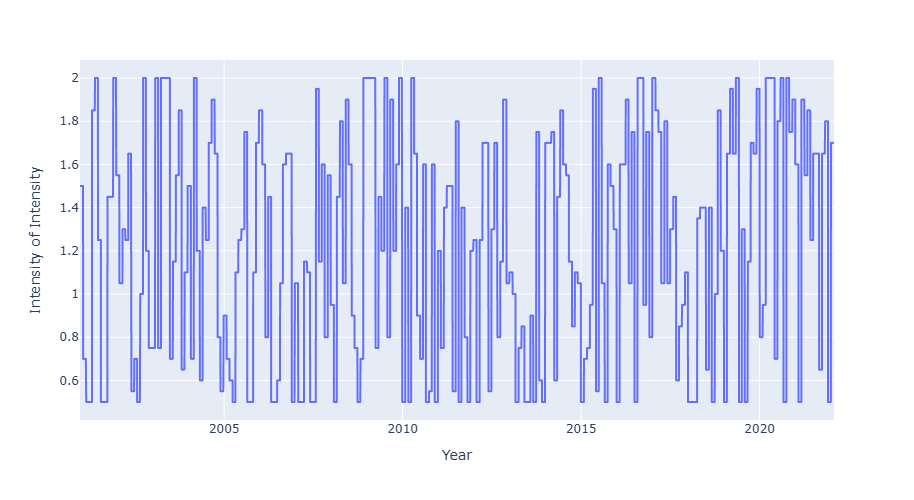

In [51]:
eval_model_outputs(oracle_int_of_int_ASINTEGER, show_fig=False)

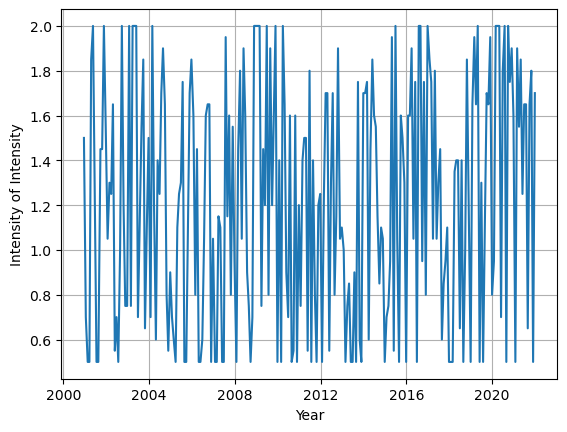

In [52]:

datetime_index = pd.to_datetime(permnos.index, format="%Y%m%d")
res_df = pd.DataFrame(np.array(oracle_intofint.astype(np.float64), dtype=float), index=datetime_index[5040:], columns=["Intensity"])
res_df = res_df.iloc[list(range(0, 5313, 21)), :]  # because we only may change intensity on every rebalancing date


fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 10})
ax.plot(res_df["Intensity"])
ax.set(xlabel='Year', ylabel='Intensity of Intensity')
ax.grid()
#fig.savefig(ioi_path + f"\\Plots\\Oracle_plot_p{PF_SIZE}.svg")

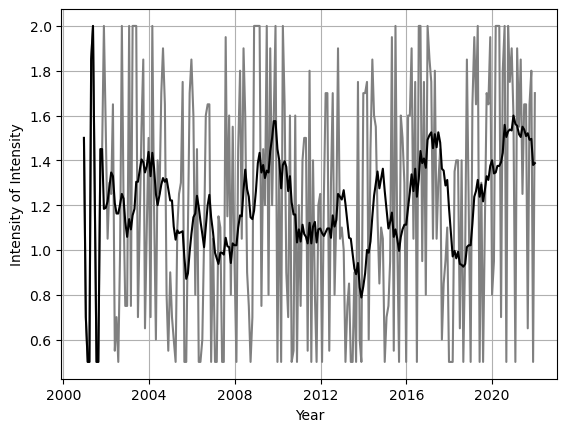

In [53]:
res_df["one-year-trend"] = res_df["Intensity"].rolling(12).mean().fillna(res_df["Intensity"])
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 10})
ax.plot(res_df["Intensity"], color="grey")
ax.plot(res_df["one-year-trend"], color="black")
ax.set(xlabel='Year', ylabel='Intensity of Intensity')
ax.grid()
#fig.savefig(ioi_path + f"\\Plots\\oracle_trend_plot_p{PF_SIZE}.svg")

In [54]:
results_path = r"H:\all\RL_Shrinkage_2024\ONE_YR\NonLinear_Shrinkage\results"
res_df.to_csv(results_path + f"\\oracle_int_of_int_p{PF_SIZE}.csv")